In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


# Read File: vmtable.csv and deployment.csv

In [ ]:
data_path = 'trace_data/vmtable/vmtable.csv'
headers=['vmid','subscriptionid','deploymentid','vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcategory', 'vmcorecount', 'vmmemory']
trace_dataframe = pd.read_csv(data_path, header=None, index_col=False,names=headers,delimiter=',')

deployment_data_path = 'trace_data/deployment/deployment.csv'
deployment_headers=['deploymentid','deploymentsize']
deployment_trace_dataframe = pd.read_csv(deployment_data_path, header=None, index_col=False,names=deployment_headers,delimiter=',')

#Compute VM Lifetime based on VM Created and VM Deleted timestamps and transform to Hour
trace_dataframe['lifetime'] = np.maximum((trace_dataframe['vmdeleted'] - trace_dataframe['vmcreated']),300)/ 3600
trace_dataframe['corehour'] = trace_dataframe['lifetime'] * trace_dataframe['vmcorecount']
trace_dataframe.head()

# General Statistics

In [ ]:
vm_count = trace_dataframe.shape[0]
subscription_count = trace_dataframe['subscriptionid'].unique().shape[0]
deployment_count = trace_dataframe['deploymentid'].unique().shape[0]
total_vm_hour_available = trace_dataframe['lifetime'].sum()
total_core_hour_available = trace_dataframe['corehour'].sum()

print("Total Number of Virtual Machines in the Dataset: %d" % vm_count)
print("Total Number of Subscriptions in the Dataset: %d" % subscription_count)
print("Total Number of Deployments in the Dataset: %d" % deployment_count)
print("Total VM Hours Available in the Dataset: %f" % total_vm_hour_available)
print("Total Core Hours Available in the Dataset: %f" % total_core_hour_available)

# Read SOSP Paper datasets

In [ ]:
lifetime_sosp = pd.read_csv('sosp_data/lifetime.txt', header=0, delimiter='\t')
cpu_sosp = pd.read_csv('sosp_data/cpu.txt', header=0, delimiter='\t')
memory_sosp = pd.Series.from_csv('sosp_data/memory.txt', header=0, sep='\t')
core_sosp = pd.Series.from_csv('sosp_data/cores.txt', header=0, sep='\t')
category_sosp = pd.Series.from_csv('sosp_data/category.txt', header=0, sep='\t')
deployment_sosp = pd.read_csv('sosp_data/deployment.txt', header=0, delimiter='\t')

# Plot Functions

In [ ]:
TraceLegend = "Azure Public Dataset"
PaperLegend = "SOSP Paper"

def CPUPlot(df, sosp):
    counts_AVG = pd.DataFrame(df.groupby('avgcpu').size().rename('Freq')).reset_index()
    counts_P95 = pd.DataFrame(df.groupby('p95maxcpu').size().rename('Freq')).reset_index()
    counts_AVG = counts_AVG.rename(columns={'avgcpu': 'Bucket'})
    counts_P95 = counts_P95.rename(columns={'p95maxcpu': 'Bucket'})
    counts_AVG['cum'] = counts_AVG['Freq'].cumsum() / counts_AVG['Freq'].sum() * 100
    counts_P95['cum'] = counts_P95['Freq'].cumsum() / counts_P95['Freq'].sum() * 100
    ax = counts_AVG.plot(x='Bucket', y='cum',linestyle='--', title="VM CPU Utilization",logx=False, legend=True, ylim=(0,100), yticks=range(0,110,20))
    sosp.plot(x='bucket', y='avg', linestyle='-', logx=False, ax=ax)
    counts_P95.plot(x='Bucket', y='cum', linestyle='--', logx=False, color='b', ax=ax)
    sosp.plot(x='bucket', y='p95', linestyle='-', logx=False, color='g', ax=ax)
    ax.text(9, 85, 'Average', size=11, weight='bold')
    ax.text(80, 30, 'P95 Max',  size=11, weight='bold')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('CPU Utilization (%)')
    ax.set_ylabel('CDF')
    ax.legend([TraceLegend, PaperLegend], loc='best');
    ax.minorticks_off()

def LifetimePlot(df, sosp):
    counts_lifetime = pd.DataFrame(df.groupby('lifetime').size().rename('Freq')).reset_index()
    counts_lifetime = counts_lifetime.rename(columns={'lifetime': 'bucket'})
    counts_lifetime['cum'] = counts_lifetime['Freq'].cumsum() / counts_lifetime['Freq'].sum() * 100
    ax = counts_lifetime[0:2500].plot(x='bucket', y='cum',linestyle='--', title="VM Lifetime",logx=False, legend=True, ylim=(0,100), yticks=range(0,110,10))
    sosp[0:2500].plot(x='bucket', y='value', linestyle='-', logx=False, ax=ax)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Lifetime (Hours)')
    ax.set_ylabel('CDF')
    ax.legend([TraceLegend, PaperLegend], loc='best');


def MemoryPlot(df, sosp):
    dataset = (df['vmmemory'].value_counts(normalize=True)*100).sort_index().to_frame().T
    paper = sosp.to_frame().T
    frames = [dataset, paper]
    result = pd.concat(frames)
    ax = result.plot.bar(stacked=True, ylim=(0,100), title='VM Memory Distribution', width=0.5, align='center')
    ax.set_xticklabels([TraceLegend, PaperLegend], rotation=0)
    ax.legend(title='Memory Size (GB)', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4);
    ax.set_ylabel('% of VMs')


def CorePlot(df, sosp):
    dataset = (df['vmcorecount'].value_counts(normalize=True)*100).sort_index().to_frame().T
    paper = sosp.to_frame().T
    frames = [dataset, paper]
    result = pd.concat(frames)
    ax = result.plot.bar(stacked=True, ylim=(0,100), title='VM Cores Distribution', width=0.5, align='center')
    ax.set_xticklabels([TraceLegend, PaperLegend], rotation=0)
    ax.set_ylabel('% of VMs')
    ax.legend(title='Core Count', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5);


def CategoryPlot(df, sosp):
    dataset = pd.DataFrame(df.groupby('vmcategory')['corehour'].sum().rename('corehour'))
    dataset = dataset.rename(columns={'vmcategory': 'Bucket'})
    dataset['cum'] = dataset['corehour']/dataset['corehour'].sum() * 100
    dataset= dataset.drop('corehour', 1)
    dataset = dataset.sort_index().T
    paper = sosp.to_frame().T
    frames = [dataset, paper]
    result = pd.concat(frames)
    ax = result.plot.bar(stacked=True, title='VM Category Distribution', color=['lightskyblue', 'orange', '0.75'])
    ax.set_ylabel('% of core hours')
    ax.set_xticklabels([TraceLegend, PaperLegend], rotation=0)
    ax.legend(["Delay-insensitive", "Interactive", "Unknown"], loc='upper center', title='Categories', bbox_to_anchor=(0.5, -0.10), ncol=3, fontsize=10.5);

def DeploymentPlot(df,sosp):
    counts_deployment = pd.DataFrame(df.groupby('deploymentsize').size().rename('Freq')).reset_index()
    counts_deployment = counts_deployment.rename(columns={'deploymentsize': 'bucket'})
    counts_deployment.to_csv('deployment.txt', sep='\t', index=False)
    counts_deployment['cum'] = counts_deployment['Freq'].cumsum() / counts_deployment['Freq'].sum() * 100
    ax = counts_deployment[0:50].plot(x='bucket', y='cum',linestyle='--', title="Deployment Size",logx=False, legend=True, ylim=(0,100), yticks=range(0,110,20))
    sosp[0:50].plot(x='bucket', y='value', linestyle='-', logx=False, ax=ax)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('# VMs')
    ax.set_ylabel('CDF')
    ax.legend([TraceLegend, PaperLegend], loc='best');


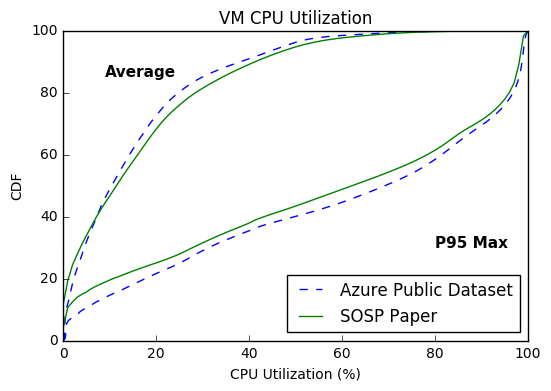

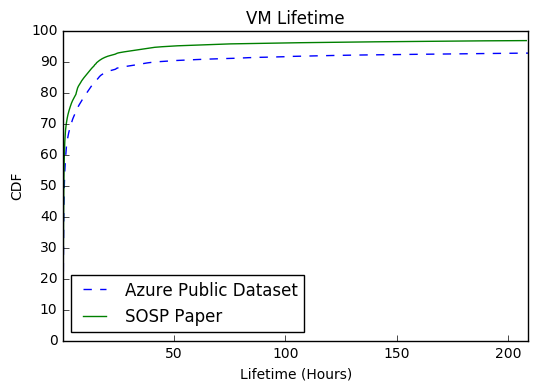

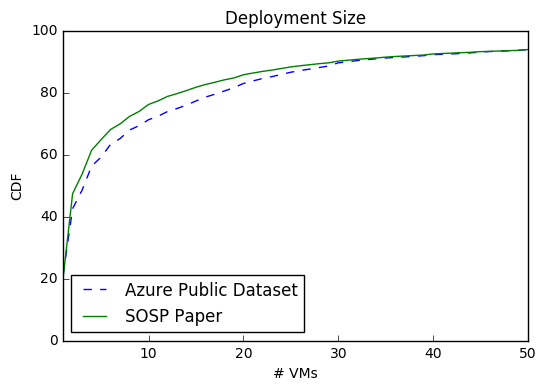

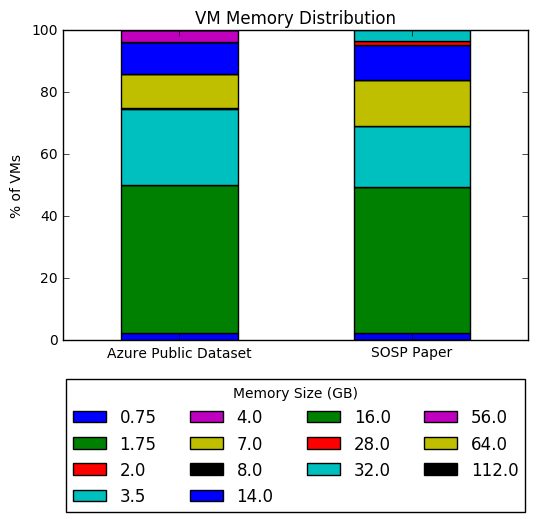

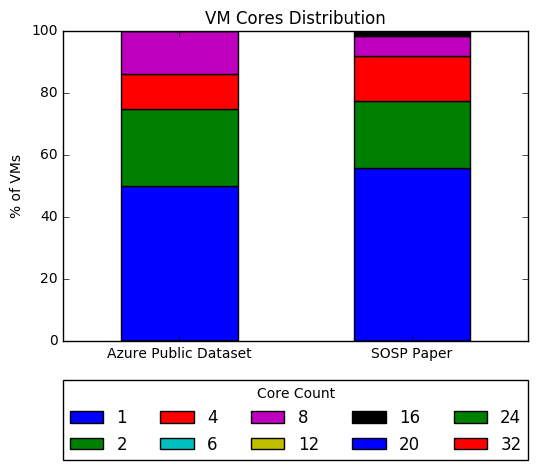

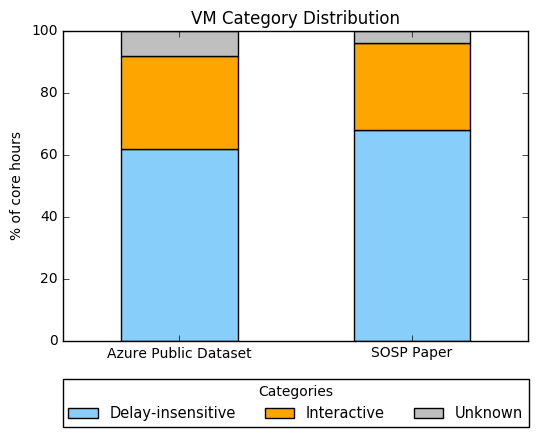

In [ ]:
CPUPlot(trace_dataframe, cpu_sosp)
LifetimePlot(trace_dataframe, lifetime_sosp)
DeploymentPlot(deployment_trace_dataframe, deployment_sosp)
MemoryPlot(trace_dataframe, memory_sosp)
CorePlot(trace_dataframe, core_sosp)
CategoryPlot(trace_dataframe, category_sosp)